In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, explained_variance_score, accuracy_score, classification_report
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carga de datos

In [ ]:
date_cols = ['idSecuencia']
ruta = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/data_ventas_stock_calendario_joined.csv"
data_ventas_stock_calendario = pd.read_csv(ruta, parse_dates=date_cols)

In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   udsStock         706640 non-null  int64         
 4   bolOpen          706640 non-null  int64         
 5   bolHoliday       706640 non-null  int64         
 6   estaEnPromocion  706640 non-null  int64         
 7   año              706640 non-null  int64         
 8   mes              706640 non-null  int64         
 9   dia              706640 non-null  int64         
 10  dia_semana       706640 non-null  int64         
 11  semana_mes       706640 non-null  int64         
 12  semana_año       706640 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 70.1 MB


In [ ]:
data_ventas_stock_calendario_out = data_ventas_stock_calendario

# **Outliers**


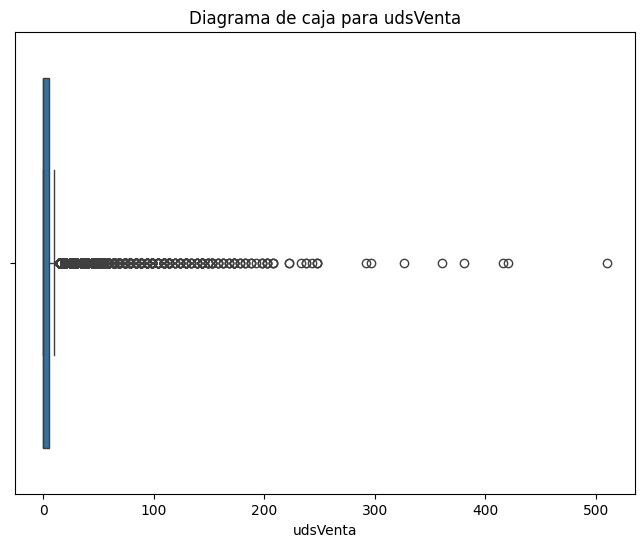

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_ventas_stock_calendario_out['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['udsVenta'] == 510]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
99024,140,2022-07-22,510,510,1,0,0,2022,7,22,4,3,29


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['producto'] == 140]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
98550,140,2021-04-04,0,475,0,1,1,2021,4,4,6,0,13
98551,140,2021-04-05,5,475,0,1,1,2021,4,5,0,0,14
98552,140,2021-04-06,10,470,1,0,1,2021,4,6,1,0,14
98553,140,2021-04-07,0,465,1,0,1,2021,4,7,2,1,14
98554,140,2021-04-08,5,663,1,0,0,2021,4,8,3,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99275,140,2023-03-30,5,183,1,0,0,2023,3,30,3,4,13
99276,140,2023-03-31,10,178,1,0,0,2023,3,31,4,4,13
99277,140,2023-04-01,0,168,1,0,0,2023,4,1,5,0,13
99278,140,2023-04-02,0,168,0,1,0,2023,4,2,6,0,13


Para los outliers de udsVentas, vamos a utilizar un umbral superior e inferior que se define como tres veces la desviación estandar. Para esos valores, se le asigna las ventas medias.

In [ ]:
# Calcular la media y la desviación estándar agrupadas por producto y mes
data_ventas_stock_calendario_out['media_ventas'] = data_ventas_stock_calendario_out.groupby(['producto', 'mes'])['udsVenta'].transform('mean')
data_ventas_stock_calendario_out['desviacion_estandar_ventas'] = data_ventas_stock_calendario_out.groupby(['producto', 'mes'])['udsVenta'].transform('std')

# Definir el umbral para outliers
umbral_multiplicador = 3  # Considerar como outliers los valores a más de 3 desviaciones estándar de la media
data_ventas_stock_calendario_out['umbral_superior'] = data_ventas_stock_calendario_out['media_ventas'] + umbral_multiplicador * data_ventas_stock_calendario_out['desviacion_estandar_ventas']
data_ventas_stock_calendario_out['umbral_inferior'] = data_ventas_stock_calendario_out['media_ventas'] - umbral_multiplicador * data_ventas_stock_calendario_out['desviacion_estandar_ventas']

data_ventas_stock_calendario_out['udsVenta_corregidas'] = np.where(data_ventas_stock_calendario_out['udsVenta'] > data_ventas_stock_calendario_out['umbral_superior'], data_ventas_stock_calendario_out['media_ventas'], data_ventas_stock_calendario_out['udsVenta'])

data_ventas_stock_calendario_out['udsVenta_corregidas'] = round(data_ventas_stock_calendario_out['udsVenta_corregidas'])


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['producto'] == 140) & (data_ventas_stock_calendario_out['mes'] == 7)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_corregidas
98638,140,2021-07-01,0,510,1,0,0,2021,7,1,3,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98639,140,2021-07-02,0,510,1,0,0,2021,7,2,4,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98640,140,2021-07-03,5,510,1,0,0,2021,7,3,5,0,26,12.096774,64.525687,205.673834,-181.480286,5.0
98641,140,2021-07-04,0,505,1,1,0,2021,7,4,6,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98642,140,2021-07-05,5,505,1,0,0,2021,7,5,0,0,27,12.096774,64.525687,205.673834,-181.480286,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99029,140,2022-07-27,0,0,1,0,0,2022,7,27,2,3,30,12.096774,64.525687,205.673834,-181.480286,0.0
99030,140,2022-07-28,0,396,1,0,0,2022,7,28,3,4,30,12.096774,64.525687,205.673834,-181.480286,0.0
99031,140,2022-07-29,0,396,1,0,0,2022,7,29,4,4,30,12.096774,64.525687,205.673834,-181.480286,0.0
99032,140,2022-07-30,0,396,0,1,0,2022,7,30,5,4,30,12.096774,64.525687,205.673834,-181.480286,0.0


Asignamos el valor de la media a aquellos registros que se salgan del umbral.

In [ ]:
# Convertir 'udsVenta_corregidas' a tipo de datos entero (int)
data_ventas_stock_calendario_out['udsVenta_corregidas'] = data_ventas_stock_calendario_out['udsVenta_corregidas'].astype(int)

# Asignar 'udsVenta_corregidas' a 'udsVenta'
data_ventas_stock_calendario_out['udsVenta'] = data_ventas_stock_calendario_out['udsVenta_corregidas']

# Eliminar la columna 'udsVenta_corregidas'
data_ventas_stock_calendario_out.drop('udsVenta_corregidas', axis=1, inplace=True)


In [ ]:
data_ventas_stock_calendario_out.isna().sum()

producto                      0
idSecuencia                   0
udsVenta                      0
udsStock                      0
bolOpen                       0
bolHoliday                    0
estaEnPromocion               0
año                           0
mes                           0
dia                           0
dia_semana                    0
semana_mes                    0
semana_año                    0
media_ventas                  0
desviacion_estandar_ventas    0
umbral_superior               0
umbral_inferior               0
dtype: int64

Según el diagrama de caja, siguen habiendo valores anómalos pero los vamos a considerar correctos.

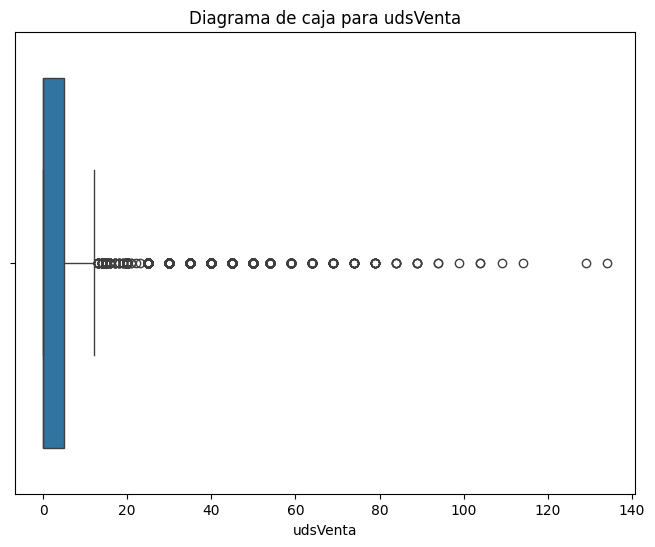

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_ventas_stock_calendario_out['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

Ahora vamos a identificar las roturas de stock y a tratarlas.

In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior
919,2,2021-10-10,0,0,0,1,1,2021,10,10,6,1,40,21.500000,16.118160,69.854480,-26.854480
921,2,2021-10-12,0,0,0,1,1,2021,10,12,1,1,41,21.500000,16.118160,69.854480,-26.854480
926,2,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,21.500000,16.118160,69.854480,-26.854480
1581,3,2021-08-03,0,0,1,0,1,2021,8,3,1,0,31,25.177419,28.042429,109.304707,-58.949869
1611,3,2021-09-02,0,0,1,0,0,2021,9,2,3,0,35,13.533333,16.768076,63.837560,-36.770894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706218,1000,2022-02-06,0,0,0,1,0,2022,2,6,6,0,5,3.214286,4.515486,16.760743,-10.332171
706271,1000,2022-03-31,0,0,1,0,0,2022,3,31,3,4,13,2.983871,3.993815,14.965315,-8.997573
706272,1000,2022-04-01,0,0,1,0,0,2022,4,1,4,0,13,2.916667,3.828048,14.400812,-8.567479
706273,1000,2022-04-02,0,0,1,0,0,2022,4,2,5,0,13,2.916667,3.828048,14.400812,-8.567479


In [ ]:
# Filtrar los datos para obtener solo los registros donde udsStock es igual a 0
data_rotura_stock = data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0)]

# Contar la cantidad de registros afectados por la rotura de stock por producto
rotura_stock_por_producto = data_rotura_stock.groupby('producto').size().reset_index(name='cantidad_registros_afectados')

# Mostrar el resultado
print(rotura_stock_por_producto)

# Opción para visualizar en una tabla
rotura_stock_por_producto

     producto  cantidad_registros_afectados
0           2                             3
1           3                             8
2           4                            12
3           5                            13
4           6                             6
..        ...                           ...
502       991                            69
503       992                            77
504       994                             1
505       999                             1
506      1000                            12

[507 rows x 2 columns]


,producto,cantidad_registros_afectados
0,2,3
1,3,8
2,4,12
3,5,13
4,6,6
...,...,...
502,991,69
503,992,77
504,994,1
505,999,1


Para tratar las roturas de stock, vamos a asignarle el valor de la media de ventas del producto en las últimas cuatro semanas según el día de la semana.


In [ ]:
data_ventas_stock_calendario_out['udsVenta_media'] = data_ventas_stock_calendario_out['udsVenta']

#Filtrar los datos para obtener solo las filas donde udsVenta = udsStock = 0
data_rotura_stock = data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0)]

#Agrupar los datos por producto y día de la semana
grouped_data = data_rotura_stock.groupby(['producto', 'dia_semana'])

#Iterar sobre cada grupo
for (producto, dia_semana), group_data in grouped_data:
    #Iterar sobre cada fila del grupo
    for index, row in group_data.iterrows():
        #Obtener la fecha y el día de la semana
        fecha = row['idSecuencia']
        dia_semana = row['dia_semana']

        #Calcular la fecha de inicio y fin de las últimas cuatro semanas
        fecha_inicio = fecha - pd.DateOffset(weeks=4)
        fecha_fin = fecha - pd.DateOffset(weeks=1)

        #Filtrar las ventas de las últimas cuatro semanas para el mismo día de la semana
        ventas_ultimas_semanas = data_ventas_stock_calendario_out[
            (data_ventas_stock_calendario_out['producto'] == producto) &
            (data_ventas_stock_calendario_out['idSecuencia'] >= fecha_inicio) &
            (data_ventas_stock_calendario_out['idSecuencia'] <= fecha_fin) &
            (data_ventas_stock_calendario_out['dia_semana'] == dia_semana)
        ]

        #Calcular la media de las ventas de las últimas cuatro semanas
        media_ventas = ventas_ultimas_semanas['udsVenta'].mean()

        #Asignar la media como el nuevo valor de udsVenta
        data_ventas_stock_calendario_out.at[index, 'udsVenta_media'] = media_ventas


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
921,2,2021-10-12,0,0,0,1,1,2021,10,12,1,1,41,21.500000,16.118160,69.854480,-26.854480,27.50
1581,3,2021-08-03,0,0,1,0,1,2021,8,3,1,0,31,25.177419,28.042429,109.304707,-58.949869,18.75
1611,3,2021-09-02,0,0,1,0,0,2021,9,2,3,0,35,13.533333,16.768076,63.837560,-36.770894,32.25
1612,3,2021-09-03,0,0,1,0,0,2021,9,3,4,0,35,13.533333,16.768076,63.837560,-36.770894,34.75
1613,3,2021-09-04,0,0,1,0,0,2021,9,4,5,0,35,13.533333,16.768076,63.837560,-36.770894,32.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706216,1000,2022-02-04,0,0,1,0,0,2022,2,4,4,0,5,3.214286,4.515486,16.760743,-10.332171,1.25
706217,1000,2022-02-05,0,0,1,0,0,2022,2,5,5,0,5,3.214286,4.515486,16.760743,-10.332171,3.00
706271,1000,2022-03-31,0,0,1,0,0,2022,3,31,3,4,13,2.983871,3.993815,14.965315,-8.997573,3.75
706272,1000,2022-04-01,0,0,1,0,0,2022,4,1,4,0,13,2.916667,3.828048,14.400812,-8.567479,3.25


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
919,2,2021-10-10,0,0,0,1,1,2021,10,10,6,1,40,21.500000,16.118160,69.854480,-26.854480,0.0
926,2,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,21.500000,16.118160,69.854480,-26.854480,0.0
1614,3,2021-09-05,0,0,0,1,0,2021,9,5,6,0,35,13.533333,16.768076,63.837560,-36.770894,0.0
1658,3,2021-10-19,0,0,1,0,1,2021,10,19,1,2,42,9.903226,13.253777,49.664558,-29.858106,0.0
2386,4,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,9.274194,11.971509,45.188721,-26.640333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700780,992,2023-03-15,0,0,1,0,0,2023,3,15,2,2,11,2.661290,4.219174,15.318812,-9.996231,0.0
706211,1000,2022-01-30,0,0,0,1,0,2022,1,30,6,4,4,1.532258,2.946060,10.370438,-7.305922,0.0
706212,1000,2022-01-31,0,0,1,0,0,2022,1,31,0,4,5,1.532258,2.946060,10.370438,-7.305922,0.0
706218,1000,2022-02-06,0,0,0,1,0,2022,2,6,6,0,5,3.214286,4.515486,16.760743,-10.332171,0.0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['producto'] == 2]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
730,2,2021-04-04,0,767,0,1,1,2021,4,4,6,0,13,22.483333,17.496238,74.972049,-30.005382,0.0
731,2,2021-04-05,0,767,0,1,1,2021,4,5,0,0,14,22.483333,17.496238,74.972049,-30.005382,0.0
732,2,2021-04-06,40,767,1,0,1,2021,4,6,1,0,14,22.483333,17.496238,74.972049,-30.005382,40.0
733,2,2021-04-07,20,728,1,0,1,2021,4,7,2,1,14,22.483333,17.496238,74.972049,-30.005382,20.0
734,2,2021-04-08,25,708,1,0,0,2021,4,8,3,1,14,22.483333,17.496238,74.972049,-30.005382,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,2023-03-30,15,554,1,0,0,2023,3,30,3,4,13,18.854839,13.783867,60.206438,-22.496761,15.0
1456,2,2023-03-31,15,545,1,0,0,2023,3,31,4,4,13,18.854839,13.783867,60.206438,-22.496761,15.0
1457,2,2023-04-01,20,535,1,0,0,2023,4,1,5,0,13,22.483333,17.496238,74.972049,-30.005382,20.0
1458,2,2023-04-02,0,515,0,1,0,2023,4,2,6,0,13,22.483333,17.496238,74.972049,-30.005382,0.0


Los que tienen 0 quiere decir que hubo un re-stock

In [ ]:
import numpy as np

# Filtrar las filas donde udsVenta = udsStock = 0 y udsVenta_media != 0 y udsVenta_media no sea NaN
filtered_data = data_ventas_stock_calendario_out[
    (data_ventas_stock_calendario_out['udsVenta'] == 0) &
    (data_ventas_stock_calendario_out['udsStock'] == 0) &
    (~data_ventas_stock_calendario_out['udsVenta_media'].isnull()) &
    (data_ventas_stock_calendario_out['udsVenta_media'] != 0)
]

# Redondear la columna udsVenta_media
filtered_data['udsVenta'] = filtered_data['udsVenta_media'].round().astype(int)

# Mostrar las filas actualizadas
print(filtered_data)

# Actualizar el DataFrame original con los valores modificados
data_ventas_stock_calendario_out.update(filtered_data)


        producto idSecuencia  udsVenta  udsStock  bolOpen  bolHoliday  \
921            2  2021-10-12        28         0        0           1   
1581           3  2021-08-03        19         0        1           0   
1611           3  2021-09-02        32         0        1           0   
1612           3  2021-09-03        35         0        1           0   
1613           3  2021-09-04        32         0        1           0   
...          ...         ...       ...       ...      ...         ...   
706216      1000  2022-02-04         1         0        1           0   
706217      1000  2022-02-05         3         0        1           0   
706271      1000  2022-03-31         4         0        1           0   
706272      1000  2022-04-01         3         0        1           0   
706273      1000  2022-04-02         2         0        1           0   

        estaEnPromocion   año  mes  dia  dia_semana  semana_mes  semana_año  \
921                   1  2021   10   12     

<ipython-input-20-e64e552cb205>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['udsVenta'] = filtered_data['udsVenta_media'].round().astype(int)


In [ ]:
data_ventas_stock_calendario_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   producto                    706640 non-null  int64         
 1   idSecuencia                 706640 non-null  datetime64[ns]
 2   udsVenta                    706640 non-null  int64         
 3   udsStock                    706640 non-null  int64         
 4   bolOpen                     706640 non-null  int64         
 5   bolHoliday                  706640 non-null  int64         
 6   estaEnPromocion             706640 non-null  int64         
 7   año                         706640 non-null  int64         
 8   mes                         706640 non-null  int64         
 9   dia                         706640 non-null  int64         
 10  dia_semana                  706640 non-null  int64         
 11  semana_mes                  706640 non-

In [ ]:
data_ventas_stock_calendario_out.isna().sum()

producto                        0
idSecuencia                     0
udsVenta                        0
udsStock                        0
bolOpen                         0
bolHoliday                      0
estaEnPromocion                 0
año                             0
mes                             0
dia                             0
dia_semana                      0
semana_mes                      0
semana_año                      0
media_ventas                    0
desviacion_estandar_ventas      0
umbral_superior                 0
umbral_inferior                 0
udsVenta_media                163
dtype: int64

In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
31390,45,2021-04-04,0,0,0,1,1,2021,4,4,6,0,13,6.416667,6.384015,25.568712,-12.735379,NaN
31391,45,2021-04-05,0,0,0,1,1,2021,4,5,0,0,14,6.416667,6.384015,25.568712,-12.735379,NaN
31392,45,2021-04-06,0,0,1,0,1,2021,4,6,1,0,14,6.416667,6.384015,25.568712,-12.735379,NaN
43070,61,2021-04-04,0,0,0,1,1,2021,4,4,6,0,13,4.250000,5.809475,21.678425,-13.178425,NaN
43071,61,2021-04-05,0,0,0,1,1,2021,4,5,0,0,14,4.250000,5.809475,21.678425,-13.178425,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700072,992,2021-04-06,0,0,1,0,0,2021,4,6,1,0,14,1.583333,3.958649,13.459281,-10.292614,NaN
700073,992,2021-04-07,0,0,1,0,0,2021,4,7,2,1,14,1.583333,3.958649,13.459281,-10.292614,NaN
700074,992,2021-04-08,0,0,1,0,0,2021,4,8,3,1,14,1.583333,3.958649,13.459281,-10.292614,NaN
700075,992,2021-04-09,0,0,1,0,0,2021,4,9,4,1,14,1.583333,3.958649,13.459281,-10.292614,NaN


# **Clustering**

Se ha probado múltiples combinaciones de clusterización y la que mejores resultados ha dado es la siguiente:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas deseadas
columnas_deseadas = ['producto', 'udsVenta', 'dia_semana']

features = data_ventas_stock_calendario_out[columnas_deseadas]

# Limpieza de datos: llenar valores faltantes con la media o cero
features.fillna(features.mean(), inplace=True)

# Estandarización de los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

<ipython-input-24-2a2a72d262f1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

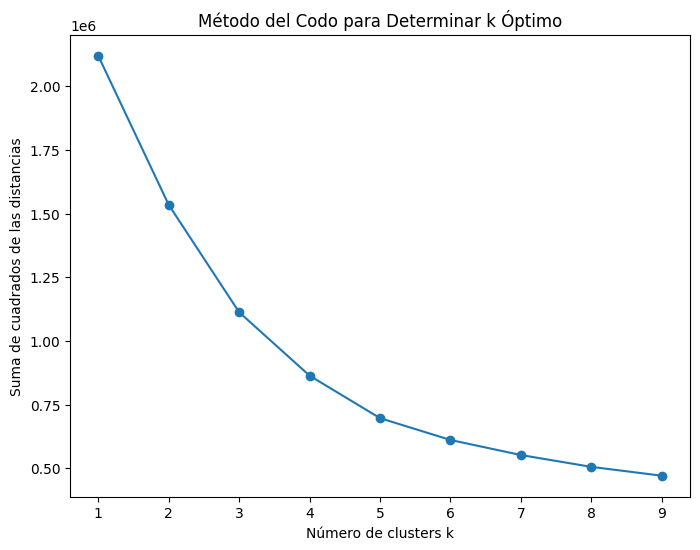

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Método del codo para encontrar el valor óptimo de k
sse = []
list_k = range(1, 10)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(features_scaled)
    sse.append(km.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters k')
plt.ylabel('Suma de cuadrados de las distancias')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


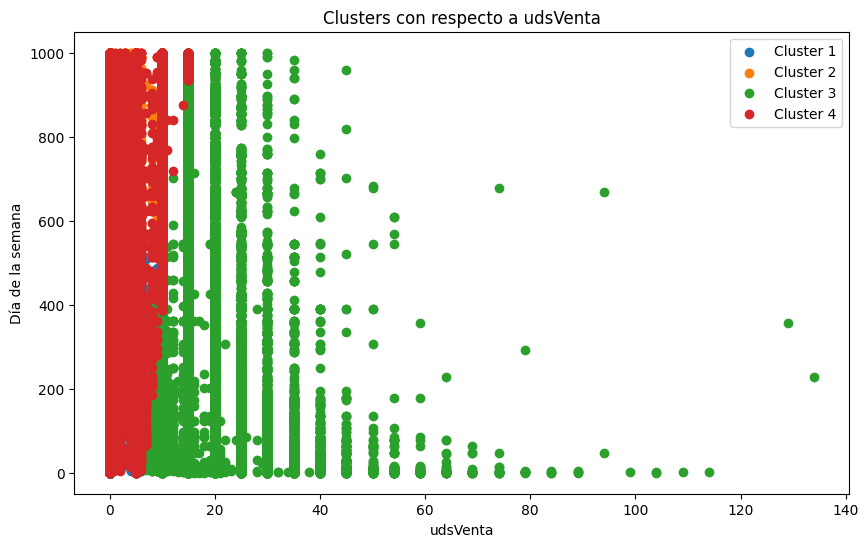

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
kmeans.fit(features_scaled)

# Obtener las etiquetas de cluster asignadas a cada punto
cluster_labels = kmeans.labels_

# Agregar las etiquetas de cluster al dataframe original
data_ventas_stock_calendario_out['cluster'] = cluster_labels

# Gráfico de los clusters con respecto a udsVenta
plt.figure(figsize=(10, 6))
for i in range(k_optimo):
    cluster_data = data_ventas_stock_calendario[data_ventas_stock_calendario_out['cluster'] == i]
    plt.scatter(cluster_data['udsVenta'], cluster_data['producto'], label=f'Cluster {i+1}')

plt.xlabel('udsVenta')
plt.ylabel('producto')
plt.title('Clusters con respecto a udsVenta')
plt.legend()
plt.show()


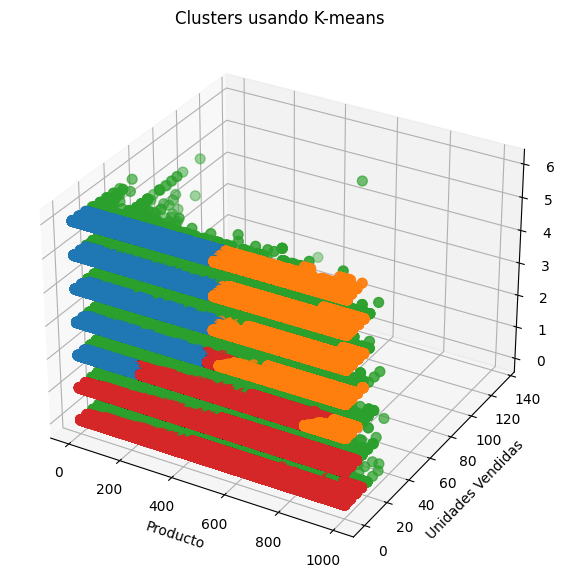

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Crear la gráfica 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignar colores a los clusters
colors = plt.cm.tab10(data_ventas_stock_calendario['cluster'].astype(float) / k)

# Graficar los puntos
scatter = ax.scatter(data_ventas_stock_calendario['producto'], data_ventas_stock_calendario['udsVenta'], data_ventas_stock_calendario['dia_semana'], c=colors, s=50)

# Etiquetas de los ejes
ax.set_xlabel('Producto')
ax.set_ylabel('Unidades Vendidas')
ax.set_zlabel('Día de la Semana')
ax.set_title('Clusters usando K-means')



# Mostrar la gráfica
plt.show()

In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 0]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
0,1,2021-04-04,0,604,0,1,1,2021,4,4,6,0,13,24.516667,20.893184,87.196219,-38.162886,0.0,0
7,1,2021-04-11,0,436,0,1,0,2021,4,11,6,1,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
14,1,2021-04-18,0,460,0,1,0,2021,4,18,6,2,15,24.516667,20.893184,87.196219,-38.162886,0.0,0
21,1,2021-04-25,0,312,0,1,0,2021,4,25,6,3,16,24.516667,20.893184,87.196219,-38.162886,0.0,0
27,1,2021-05-01,0,436,0,1,0,2021,5,1,5,0,17,23.919355,17.074858,75.143928,-27.305218,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373688,527,2023-01-22,0,99,0,1,0,2023,1,22,6,3,3,4.435484,5.364183,20.528033,-11.657065,0.0,0
373737,527,2023-03-12,0,40,0,1,0,2023,3,12,6,1,10,3.790323,4.932785,18.588676,-11.008031,0.0,0
373744,527,2023-03-19,0,69,0,1,0,2023,3,19,6,2,11,3.790323,4.932785,18.588676,-11.008031,0.0,0
373751,527,2023-03-26,0,94,0,1,0,2023,3,26,6,3,12,3.790323,4.932785,18.588676,-11.008031,0.0,0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['año'] == 2023]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
637,1,2023-01-01,0,490,0,1,0,2023,1,1,6,0,52,16.564516,19.951269,76.418324,-43.289292,0.0,0
638,1,2023-01-02,30,490,1,0,0,2023,1,2,0,0,1,16.564516,19.951269,76.418324,-43.289292,30.0,2
639,1,2023-01-03,30,460,1,0,0,2023,1,3,1,0,1,16.564516,19.951269,76.418324,-43.289292,30.0,2
640,1,2023-01-04,0,688,1,0,0,2023,1,4,2,0,1,16.564516,19.951269,76.418324,-43.289292,0.0,0
641,1,2023-01-05,35,688,1,0,0,2023,1,5,3,0,1,16.564516,19.951269,76.418324,-43.289292,35.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1
706638,1000,2023-04-02,0,109,0,1,0,2023,4,2,6,0,13,2.916667,3.828048,14.400812,-8.567479,0.0,1


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 1]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
363699,514,2021-09-10,8,0,1,0,0,2021,9,10,4,1,36,1.833333,3.440372,12.154449,-8.487782,7.5,1
365735,517,2021-04-09,5,89,1,0,0,2021,4,9,4,1,14,1.583333,2.836157,10.091804,-6.925137,5.0,1
365742,517,2021-04-16,5,69,1,0,0,2021,4,16,4,2,15,1.583333,2.836157,10.091804,-6.925137,5.0,1
365756,517,2021-04-30,5,109,1,0,0,2021,4,30,4,4,17,1.583333,2.836157,10.091804,-6.925137,5.0,1
365763,517,2021-05-07,5,99,1,0,0,2021,5,7,4,1,18,2.419355,3.592106,13.195673,-8.356963,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706634,1000,2023-03-29,0,109,1,0,0,2023,3,29,2,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1


In [ ]:
data_ventas_stock_calendario_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   producto                    706640 non-null  int64         
 1   idSecuencia                 706640 non-null  datetime64[ns]
 2   udsVenta                    706640 non-null  int64         
 3   udsStock                    706640 non-null  int64         
 4   bolOpen                     706640 non-null  int64         
 5   bolHoliday                  706640 non-null  int64         
 6   estaEnPromocion             706640 non-null  int64         
 7   año                         706640 non-null  int64         
 8   mes                         706640 non-null  int64         
 9   dia                         706640 non-null  int64         
 10  dia_semana                  706640 non-null  int64         
 11  semana_mes                  706640 non-

# **Entrenamiento PRE-LIMPIEZA SOLO CLUSTERING (PRUEBAS M2)**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
data_ventas_stock_calendario_out_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   bolOpen          706640 non-null  int64         
 4   bolHoliday       706640 non-null  int64         
 5   estaEnPromocion  706640 non-null  int64         
 6   año              706640 non-null  int64         
 7   mes              706640 non-null  int64         
 8   dia              706640 non-null  int64         
 9   dia_semana       706640 non-null  int64         
 10  semana_mes       706640 non-null  int64         
 11  semana_año       706640 non-null  int64         
 12  cluster          706640 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(11)
memory usage: 67.4 MB


In [ ]:
# Define las fechas de inicio y fin para los conjuntos de prueba y validación
fecha_inicio_prueba = '2022-09-01'
fecha_fin_prueba = '2022-12-01'
fecha_inicio_validacion = '2022-06-01'
fecha_fin_validacion = '2022-09-01'

# Filtra los datos para obtener el conjunto de prueba
test = data_ventas_stock_calendario_out_red[
    (data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba)
]

# Filtra los datos para obtener el conjunto de validación
validation = data_ventas_stock_calendario_out_red[
    (data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_validacion) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_validacion)
]

# Filtra los datos para obtener el conjunto de entrenamiento
train = data_ventas_stock_calendario_out_red[
    ~(data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_validacion) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_inicio_prueba)
]

# Verifica el tamaño de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

# Mostrar los primeros registros de cada conjunto para verificar
print("Primeros registros del conjunto de entrenamiento:")
print(train.head())
print("\nPrimeros registros del conjunto de validación:")
print(validation.head())
print("\nPrimeros registros del conjunto de prueba:")
print(test.head())

Tamaño del conjunto de entrenamiento: 409464
Tamaño del conjunto de validación: 89056
Tamaño del conjunto de prueba: 88088
Primeros registros del conjunto de entrenamiento:
   producto idSecuencia  udsVenta  bolOpen  bolHoliday  estaEnPromocion   año  \
0         1  2021-04-04         0        0           1                1  2021   
1         1  2021-04-05         0        0           1                1  2021   
2         1  2021-04-06        45        1           0                1  2021   
3         1  2021-04-07        59        1           0                1  2021   
4         1  2021-04-08        10        1           0                0  2021   

   mes  dia  dia_semana  semana_mes  semana_año  cluster  
0    4    4           6           0          13        1  
1    4    5           0           0          14        0  
2    4    6           1           0          14        3  
3    4    7           2           1          14        3  
4    4    8           3           1          

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar y entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_rf.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_rf.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Error cuadrático medio en el conjunto de validación: 22.529195876751707
Error cuadrático medio en el conjunto de prueba: 17.903657955680682


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 4.746493008185276
RMSE test: 4.231271434885818


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5580126963136998


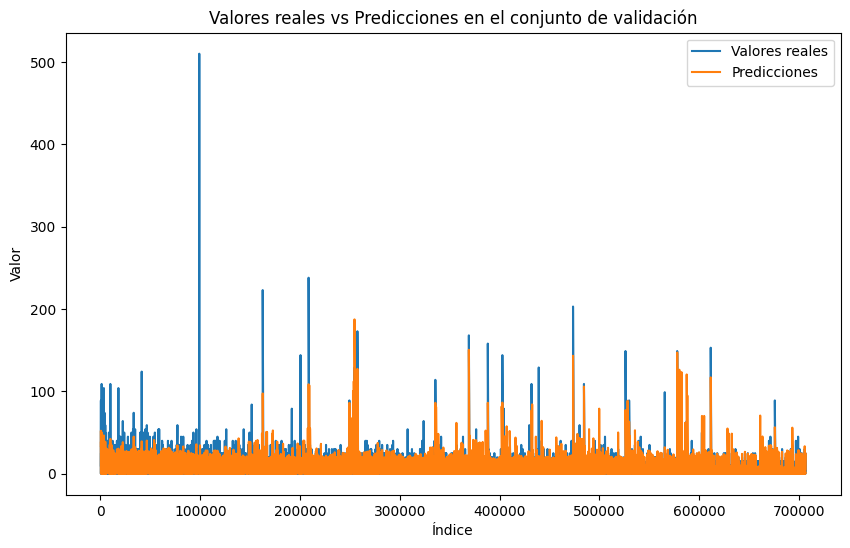

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.5330672711749836
Coeficiente de determinación en el conjunto de prueba: 0.5568085047401992


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/10
12796/12796 [==============================] - 76s 6ms/step - loss: 34.3265 - val_loss: 28.6114
Epoch 2/10
12796/12796 [==============================] - 64s 5ms/step - loss: 28.7649 - val_loss: 29.4275
Epoch 3/10
12796/12796 [==============================] - 66s 5ms/step - loss: 28.1022 - val_loss: 27.9387
Epoch 4/10
12796/12796 [==============================] - 65s 5ms/step - loss: 26.4913 - val_loss: 24.9356
Epoch 5/10
12796/12796 [==============================] - 65s 5ms/step - loss: 24.8256 - val_loss: 24.3107
Epoch 6/10
12796/12796 [==============================] - 67s 5ms/step - loss: 26.9961 - val_loss: 27.9680
Epoch 7/10
12796/12796 [==============================] - 65s 5ms/step - loss: 27.3765 - val_loss: 33.3217
Epoch 8/10
12796/12796 [==============================] - 70s 5ms/step - loss: 26.0606 - val_loss: 25.1622
Epoch 9/10
12796/12796 [==============================] - 64s 5ms/step - loss: 24.9357 - val_loss: 24.7648
Epoch 10/10
2783/2783 [==============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 5.237457046972319
RMSE test: 4.747991118103582


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.48089045997412705


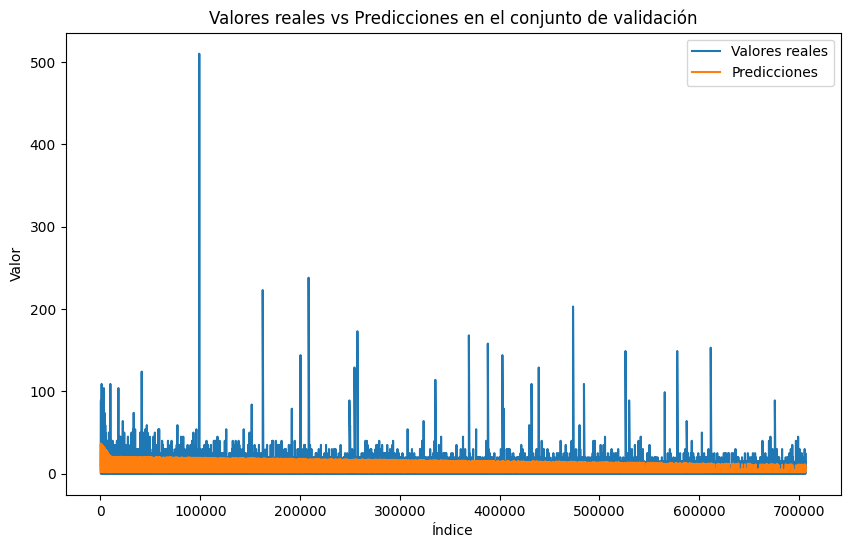

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.4314749910150275
Coeficiente de determinación en el conjunto de prueba: 0.44195471723996815


In [ ]:
pip install xgboost

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo XGBoost con los parámetros dados
modelo_xgb = XGBRegressor(n_estimators=500, max_depth=7, min_samples_split=5, learning_rate=0.01, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
modelo_xgb.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_xgb.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_xgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:10:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Error cuadrático medio en el conjunto de validación: 21.19501291378555
Error cuadrático medio en el conjunto de prueba: 15.674730768824757


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 4.6038041784795265
RMSE test: 3.959132577828729


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.6121233256494882


In [ ]:
# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.560719109929357
Coeficiente de determinación en el conjunto de prueba: 0.611983909409638


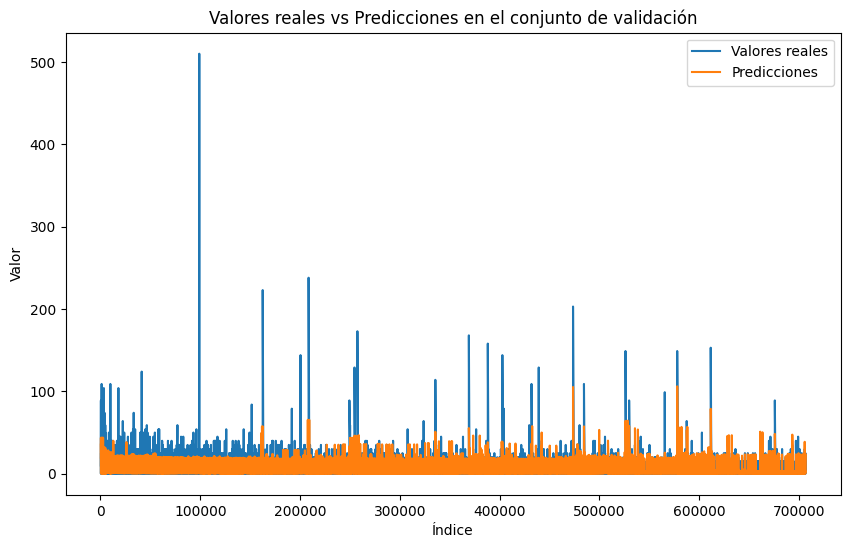

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


DT

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo Decision Tree con los parámetros dados
modelo_dt = DecisionTreeRegressor(max_depth=7, min_samples_split=5, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
modelo_dt.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_dt.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_dt.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

Error cuadrático medio en el conjunto de validación: 22.175394927871835
Error cuadrático medio en el conjunto de prueba: 17.144870158331884


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 4.70907580400569
RMSE test: 4.14063644363181


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5756907770477037


LGBM

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo LightGBM con los parámetros dados
modelo_lgbm = lgb.LGBMRegressor(n_estimators=500, max_depth=7, min_samples_split=5, learning_rate=0.01, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
modelo_lgbm.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_lgbm.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_lgbm.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 409464, number of used features: 11
[LightGBM] [Info] Start training from score 3.818639
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Error cuadrático medio en el c

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 4.66946139600571
RMSE test: 3.979777690611849


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.6082416075945869


# **Entrenamiento PRE-LIMPIEZA RNN (PRUEBAS)**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
train = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31']
# Validación: desde 2023-01-01 hasta 2023-02-28
validation = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28')]
# Prueba: desde 2023-03-01 hasta 2023-04-03
test = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01']

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 616616
Tamaño del conjunto de validación: 57112
Tamaño del conjunto de prueba: 32912


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/10
19270/19270 [==============================] - 42s 2ms/step - loss: 32.0484 - val_loss: 25.5695
Epoch 2/10
19270/19270 [==============================] - 40s 2ms/step - loss: 25.1350 - val_loss: 23.5893
Epoch 3/10
19270/19270 [==============================] - 40s 2ms/step - loss: 23.7199 - val_loss: 20.2821
Epoch 4/10
19270/19270 [==============================] - 40s 2ms/step - loss: 19.9275 - val_loss: 18.3593
Epoch 5/10
19270/19270 [==============================] - 39s 2ms/step - loss: 16.4187 - val_loss: 15.7821
Epoch 6/10
19270/19270 [==============================] - 38s 2ms/step - loss: 14.5775 - val_loss: 13.6562
Epoch 7/10
19270/19270 [==============================] - 41s 2ms/step - loss: 14.0485 - val_loss: 12.8800
Epoch 8/10
19270/19270 [==============================] - 39s 2ms/step - loss: 13.8789 - val_loss: 13.1217
Epoch 9/10
19270/19270 [==============================] - 41s 2ms/step - loss: 13.8075 - val_loss: 15.1972
Epoch 10/10
1785/1785 [==============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.990928176063636
RMSE test: 3.776509432726069


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5481724583670748


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/20
19270/19270 [==============================] - 47s 2ms/step - loss: 25.9836 - val_loss: 22.2053
Epoch 2/20
19270/19270 [==============================] - 46s 2ms/step - loss: 20.0095 - val_loss: 18.1657
Epoch 3/20
19270/19270 [==============================] - 45s 2ms/step - loss: 17.8024 - val_loss: 16.3260
Epoch 4/20
19270/19270 [==============================] - 45s 2ms/step - loss: 16.4662 - val_loss: 16.4013
Epoch 5/20
19270/19270 [==============================] - 44s 2ms/step - loss: 14.0582 - val_loss: 13.7807
Epoch 6/20
19270/19270 [==============================] - 46s 2ms/step - loss: 13.1163 - val_loss: 12.2581
Epoch 7/20
19270/19270 [==============================] - 46s 2ms/step - loss: 12.9948 - val_loss: 12.3721
Epoch 8/20
19270/19270 [==============================] - 45s 2ms/step - loss: 12.9073 - val_loss: 11.8805
Epoch 9/20
19270/19270 [==============================] - 47s 2ms/step - loss: 12.8486 - val_loss: 12.1483
Epoch 10/20
19270/19270 [============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.4742487577600785
RMSE test: 3.2943858713769814


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.611874587698827


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/50
19270/19270 [==============================] - 151s 8ms/step - loss: 25.5658 - val_loss: 23.5293
Epoch 2/50
19270/19270 [==============================] - 145s 8ms/step - loss: 21.6554 - val_loss: 18.7992
Epoch 3/50
19270/19270 [==============================] - 141s 7ms/step - loss: 17.7284 - val_loss: 15.5428
Epoch 4/50
19270/19270 [==============================] - 149s 8ms/step - loss: 15.3905 - val_loss: 18.5069
Epoch 5/50
19270/19270 [==============================] - 146s 8ms/step - loss: 14.3761 - val_loss: 15.7246
Epoch 6/50
19270/19270 [==============================] - 132s 7ms/step - loss: 14.0905 - val_loss: 15.8163
Epoch 7/50
19270/19270 [==============================] - 133s 7ms/step - loss: 13.9423 - val_loss: 13.9112
Epoch 8/50
19270/19270 [==============================] - 137s 7ms/step - loss: 13.8428 - val_loss: 13.6643
Epoch 9/50
19270/19270 [==============================] - 133s 7ms/step - loss: 13.7517 - val_loss: 13.4136
Epoch 10/50
19270/19270 [===

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.614058230706216
RMSE test: 3.4049341425670776


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5838708197761857


# **Entrenamiento PRE-LIMPIEZA XGboost con hiperparámetros (PRUEBAS)**

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
Error cuadrático medio en el conjunto de validación: 10.695816299758132
Error cuadrático medio en el conjunto de prueba: 9.726468745523498
RMSE val: 3.2704458869943305
RMSE test: 3.1187287066244633
Explained Variance Score: 0.6469516316140164


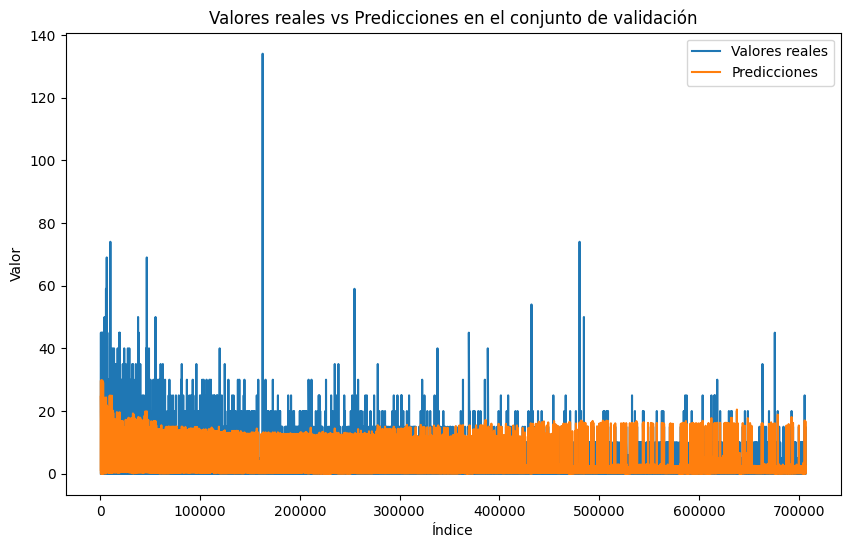

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
Error cuadrático medio en el conjunto de validación: 10.695816299758132
Error cuadrático medio en el conjunto de prueba: 9.726468745523498
RMSE val: 3.2704458869943305
RMSE test: 3.1187287066244633
Explained Variance Score: 0.6469516316140164


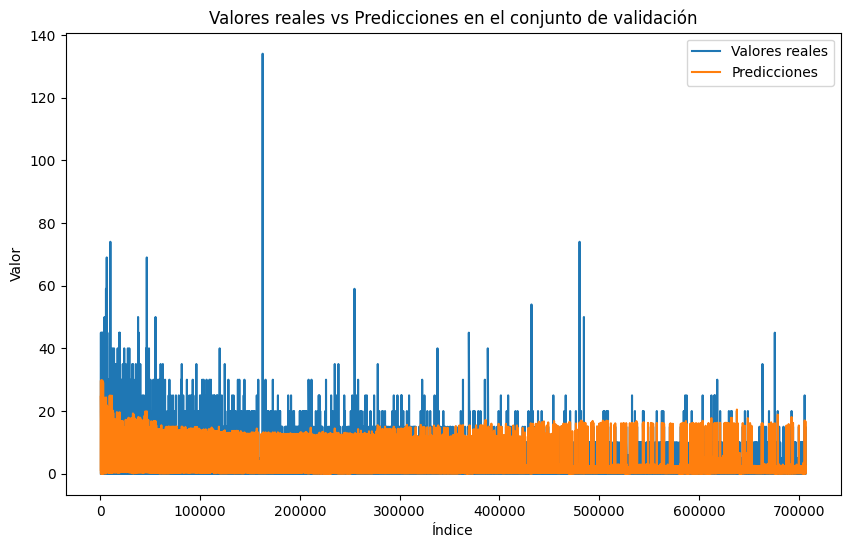

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo Naive Bayes Gaussiano
modelo_nb = GaussianNB()

# Ajustar el modelo Naive Bayes a los datos de entrenamiento
modelo_nb.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_nb.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_nb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


Error cuadrático medio en el conjunto de validación: 73.22464630900686
Error cuadrático medio en el conjunto de prueba: 104.05596742829363
RMSE val: 8.557140077678223
RMSE test: 10.200782687043853


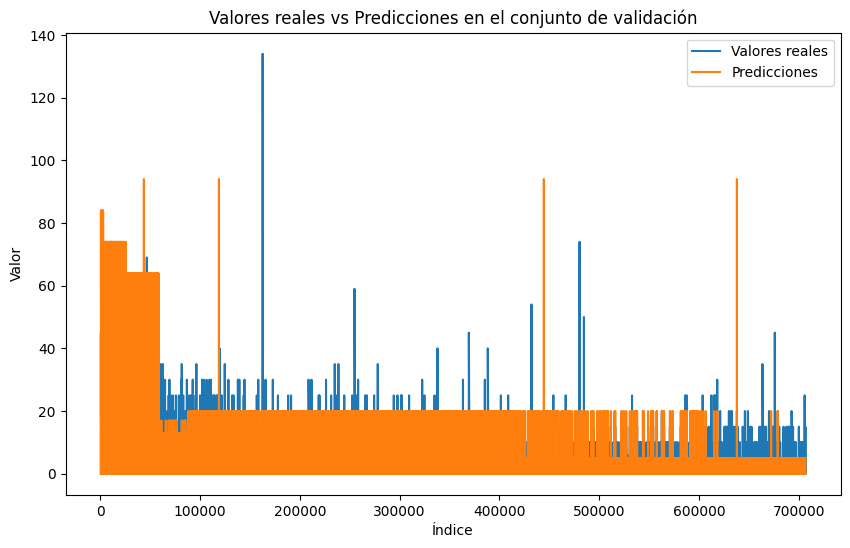

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: -2.1693223467019984


# **Entrenamiento eliminando features (dia, mes y año) (PRUEBAS)**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
train = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31']
# Validación: desde 2023-01-01 hasta 2023-02-28
validation = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28')]
# Prueba: desde 2023-03-01 hasta 2023-04-03
test = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01']

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 616616
Tamaño del conjunto de validación: 57112
Tamaño del conjunto de prueba: 32912


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
Error cuadrático medio en el conjunto de validación: 10.689191353097941
Error cuadrático medio en el conjunto de prueba: 9.73022622642666
RMSE val: 3.26943287943
RMSE test: 3.1193310543170405
Explained Variance Score: 0.646960145274837


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/10
19270/19270 [==============================] - 69s 4ms/step - loss: 17.7240 - val_loss: 13.3226
Epoch 2/10
19270/19270 [==============================] - 65s 3ms/step - loss: 13.0084 - val_loss: 12.3749
Epoch 3/10
19270/19270 [==============================] - 70s 4ms/step - loss: 12.4574 - val_loss: 12.2629
Epoch 4/10
19270/19270 [==============================] - 68s 4ms/step - loss: 12.2601 - val_loss: 14.6788
Epoch 5/10
19270/19270 [==============================] - 62s 3ms/step - loss: 12.2500 - val_loss: 12.4228
Epoch 6/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.7985 - val_loss: 14.9726
Epoch 7/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.1100 - val_loss: 11.5678
Epoch 8/10
19270/19270 [==============================] - 65s 3ms/step - loss: 12.0230 - val_loss: 11.3159
Epoch 9/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.2194 - val_loss: 11.6824
Epoch 10/10
1785/1785 [==============

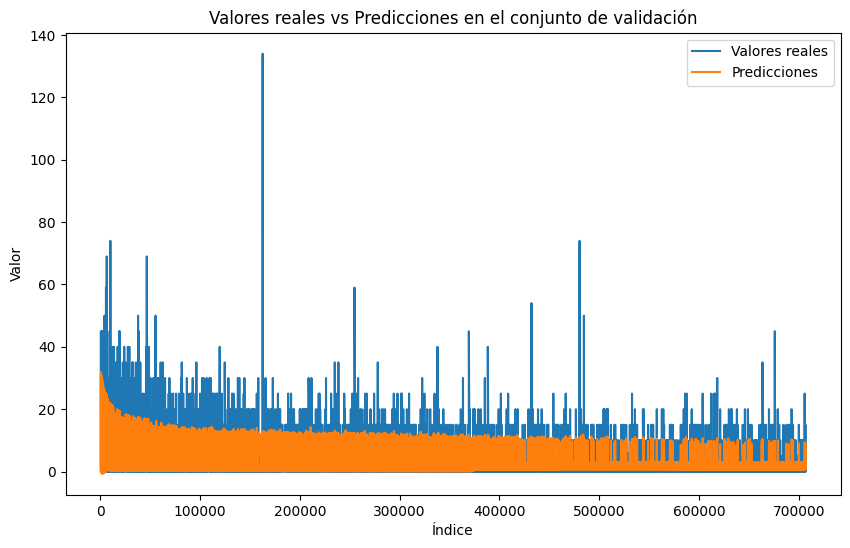

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Crear un DataFrame con los valores reales y las predicciones
data = pd.DataFrame({
    'Real_Values': y_test,
    'Predicted_Values': predicciones_prueba.flatten()  # Usar flatten() si las predicciones son en forma de array 2D
})

# Mostrar las primeras filas del DataFrame
print(data.head())


     Real_Values  Predicted_Values
696           20         29.529213
697           10         31.010365
698           30         32.050114
699           25         32.836464
700            0          1.174260


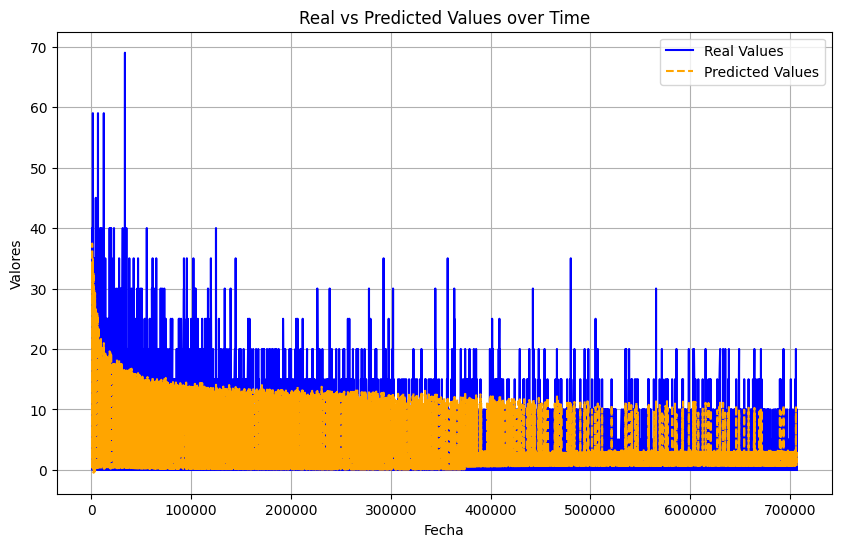

In [ ]:
# Graficar las series temporales de valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Real_Values'], label='Real Values', color='blue')
plt.plot(data.index, data['Predicted_Values'], label='Predicted Values', linestyle='--', color='orange')

# Personalizar el gráfico
plt.title('Real vs Predicted Values over Time')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/20
19270/19270 [==============================] - 142s 7ms/step - loss: 17.0292 - val_loss: 12.9060
Epoch 2/20
19270/19270 [==============================] - 139s 7ms/step - loss: 12.8864 - val_loss: 12.0432
Epoch 3/20
19270/19270 [==============================] - 134s 7ms/step - loss: 12.4798 - val_loss: 12.7906
Epoch 4/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.1730 - val_loss: 13.4567
Epoch 5/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.3056 - val_loss: 14.0574
Epoch 6/20
19270/19270 [==============================] - 135s 7ms/step - loss: 12.0396 - val_loss: 11.6019
Epoch 7/20
19270/19270 [==============================] - 137s 7ms/step - loss: 12.1447 - val_loss: 12.1248
Epoch 8/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.4277 - val_loss: 12.5967
Epoch 9/20
19270/19270 [==============================] - 134s 7ms/step - loss: 12.1730 - val_loss: 12.0192
Epoch 10/20
19270/19270 [===

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=500, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/50
19270/19270 [==============================] - 423s 22ms/step - loss: 16.6327 - val_loss: 12.8202
Epoch 2/50
19270/19270 [==============================] - 422s 22ms/step - loss: 12.8516 - val_loss: 12.8061
Epoch 3/50
19270/19270 [==============================] - 427s 22ms/step - loss: 12.3362 - val_loss: 12.0145
Epoch 4/50
19270/19270 [==============================] - 422s 22ms/step - loss: 12.1779 - val_loss: 11.4230
Epoch 5/50
19270/19270 [==============================] - 419s 22ms/step - loss: 12.0647 - val_loss: 12.0126
Epoch 6/50
19270/19270 [==============================] - 424s 22ms/step - loss: 12.0035 - val_loss: 11.3612
Epoch 7/50
19270/19270 [==============================] - 416s 22ms/step - loss: 11.9249 - val_loss: 11.3779
Epoch 8/50
19270/19270 [==============================] - 420s 22ms/step - loss: 11.9368 - val_loss: 11.5658
Epoch 9/50
19270/19270 [==============================] - 419s 22ms/step - loss: 11.8397 - val_loss: 11.3157
Epoch 10/50
19270/1

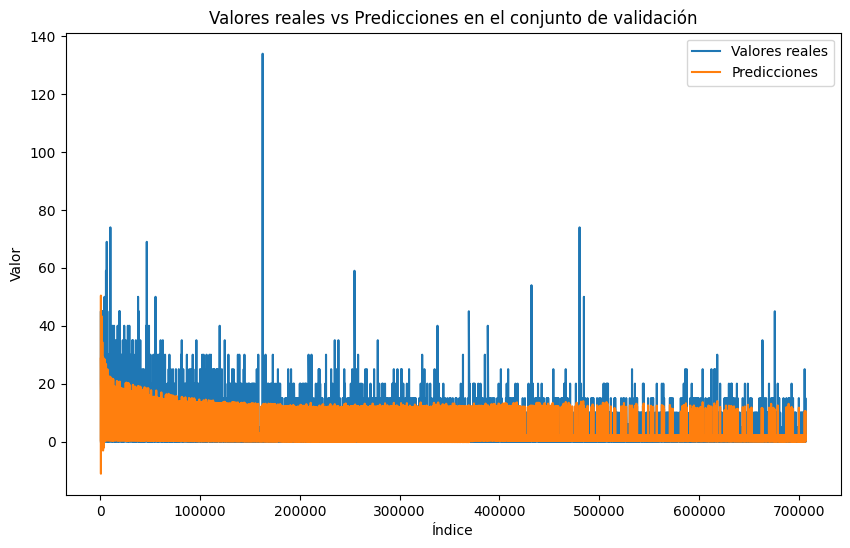

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


# **Entrenamiento con modelo por cluster (PRUEBAS)**

In [ ]:
# Seleccionar las columnas deseadas
columnas_deseadas = ['producto', 'udsVenta']

features = data_ventas_stock_calendario_out[columnas_deseadas]

# Limpieza de datos: llenar valores faltantes con la media o cero
features.fillna(features.mean(), inplace=True)

# Estandarización de los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

<ipython-input-24-6f16fb184b7b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

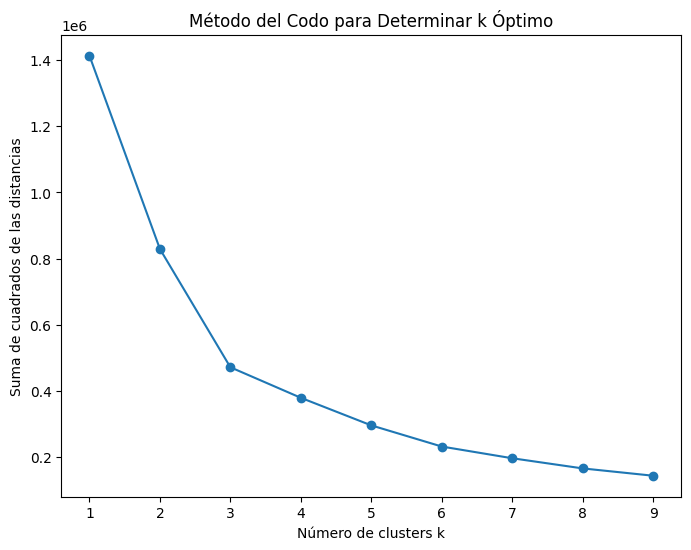

In [ ]:
# Método del codo para encontrar el valor óptimo de k
sse = []
list_k = range(1, 10)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(features_scaled)
    sse.append(km.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters k')
plt.ylabel('Suma de cuadrados de las distancias')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


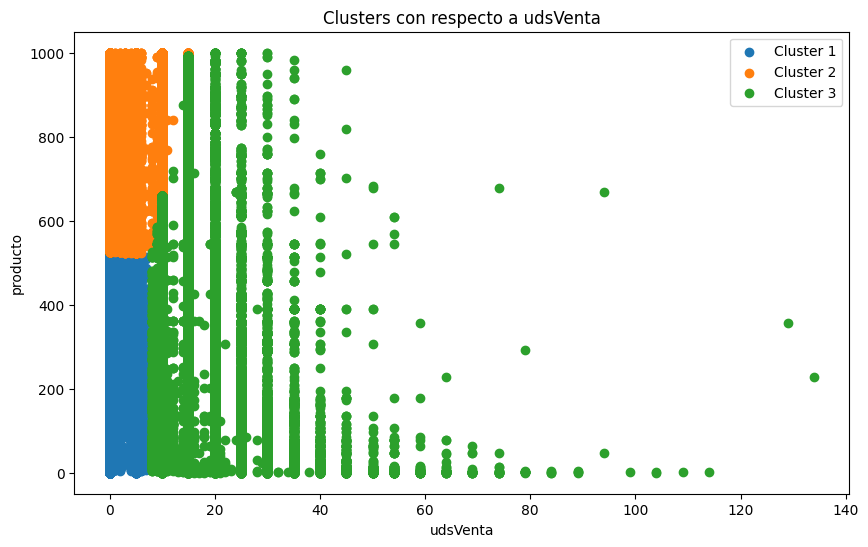

In [ ]:
# Ajustar el modelo KMeans con el número óptimo de clusters
k_optimo = 3  # Debes cambiar esto con el valor óptimo determinado por el método del codo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
kmeans.fit(features_scaled)  # Suponiendo que "features_scaled" es tu conjunto de datos escalados

# Obtener las etiquetas de cluster asignadas a cada punto
cluster_labels = kmeans.labels_

# Agregar las etiquetas de cluster al dataframe original
data_ventas_stock_calendario_out['cluster'] = cluster_labels

# Gráfico de los clusters con respecto a udsVenta
plt.figure(figsize=(10, 6))
for i in range(k_optimo):
    cluster_data = data_ventas_stock_calendario[data_ventas_stock_calendario_out['cluster'] == i]
    plt.scatter(cluster_data['udsVenta'], cluster_data['producto'], label=f'Cluster {i+1}')

plt.xlabel('udsVenta')
plt.ylabel('producto')
plt.title('Clusters con respecto a udsVenta')
plt.legend()
plt.show()


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 0]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
0,1,2021-04-04,0,604,0,1,1,2021,4,4,6,0,13,24.516667,20.893184,87.196219,-38.162886,0.0,0
1,1,2021-04-05,0,604,0,1,1,2021,4,5,0,0,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
7,1,2021-04-11,0,436,0,1,0,2021,4,11,6,1,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
14,1,2021-04-18,0,460,0,1,0,2021,4,18,6,2,15,24.516667,20.893184,87.196219,-38.162886,0.0,0
21,1,2021-04-25,0,312,0,1,0,2021,4,25,6,3,16,24.516667,20.893184,87.196219,-38.162886,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373023,526,2023-03-28,0,208,1,0,0,2023,3,28,1,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373024,526,2023-03-29,0,208,1,0,0,2023,3,29,2,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373026,526,2023-03-31,0,158,1,0,0,2023,3,31,4,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373027,526,2023-04-01,0,158,1,0,0,2023,4,1,5,0,13,2.083333,4.247798,14.826726,-10.660060,0.0,0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 1]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
370115,523,2021-04-09,5,59,1,0,0,2021,4,9,4,1,14,4.333333,5.999058,22.330508,-13.663842,5.0,1
370116,523,2021-04-10,5,54,1,0,0,2021,4,10,5,1,14,4.333333,5.999058,22.330508,-13.663842,5.0,1
370125,523,2021-04-19,5,69,1,0,0,2021,4,19,0,2,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
370126,523,2021-04-20,5,64,1,0,0,2021,4,20,1,2,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
370127,523,2021-04-21,5,59,1,0,0,2021,4,21,2,3,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1
706638,1000,2023-04-02,0,109,0,1,0,2023,4,2,6,0,13,2.916667,3.828048,14.400812,-8.567479,0.0,1


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 2]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
2,1,2021-04-06,45,604,1,0,1,2021,4,6,1,0,14,24.516667,20.893184,87.196219,-38.162886,45.0,2
3,1,2021-04-07,59,554,1,0,1,2021,4,7,2,1,14,24.516667,20.893184,87.196219,-38.162886,59.0,2
4,1,2021-04-08,10,495,1,0,0,2021,4,8,3,1,14,24.516667,20.893184,87.196219,-38.162886,10.0,2
5,1,2021-04-09,45,490,1,0,0,2021,4,9,4,1,14,24.516667,20.893184,87.196219,-38.162886,45.0,2
6,1,2021-04-10,10,446,1,0,0,2021,4,10,5,1,14,24.516667,20.893184,87.196219,-38.162886,10.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705788,999,2022-12-03,20,124,1,0,0,2022,12,3,5,0,48,5.241935,6.740349,25.462984,-14.979113,20.0,2
705815,999,2022-12-30,20,109,1,0,0,2022,12,30,4,4,52,5.241935,6.740349,25.462984,-14.979113,20.0,2
705819,999,2023-01-03,25,84,1,0,0,2023,1,3,1,0,1,5.564516,7.192029,27.140602,-16.011570,25.0,2
705892,999,2023-03-17,20,173,1,0,0,2023,3,17,4,2,11,4.354839,5.393064,20.534031,-11.824354,20.0,2


Entrenamiento

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
# Para el cluster 0
train_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]
validation_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]
test_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]

# Para el cluster 1
train_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]
validation_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]
test_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]

# Para el cluster 2
train_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]
validation_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]
test_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de prueba (Cluster 0):", len(test_c0))
print("Tamaño del conjunto de prueba (Cluster 1):", len(test_c1))
print("Tamaño del conjunto de prueba (Cluster 2):", len(test_c2))


Tamaño del conjunto de prueba (Cluster 0): 13616
Tamaño del conjunto de prueba (Cluster 1): 14937
Tamaño del conjunto de prueba (Cluster 2): 4359


In [ ]:
# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Definir el rango de hiperparámetros a probar
    param_grid = {
        'n_estimators': [250, 500],
        'max_depth': [2, 4, 6]
    }

    # Inicializar el modelo RandomForestRegressor
    rf = RandomForestRegressor(random_state=42)

    # Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Ajustar GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print(f"Mejores hiperparámetros (Cluster {cluster}):", best_params)

    # Obtener el mejor modelo
    best_rf_model = grid_search.best_estimator_

    # Hacer predicciones en el conjunto de prueba usando el mejor modelo
    predicciones = best_rf_model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)


Mejores hiperparámetros (Cluster c0): {'max_depth': 4, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c0): 4.668485520580282
Mejores hiperparámetros (Cluster c1): {'max_depth': 6, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c1): 7.111048848773684
Mejores hiperparámetros (Cluster c2): {'max_depth': 4, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c2): 30.906698934892706


In [ ]:
# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Definir el rango de hiperparámetros a probar
    param_grid = {
        'n_estimators': [250, 500, 1000, 2000],
        'max_depth': [2, 4, 6, 10]
    }

    # Inicializar el modelo XGBRegressor
    xgb = XGBRegressor(random_state=42)

    # Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Ajustar GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print(f"Mejores hiperparámetros (Cluster {cluster}):", best_params)

    # Obtener el mejor modelo
    best_xgb_model = grid_search.best_estimator_

    # Hacer predicciones en el conjunto de prueba usando el mejor modelo
    predicciones = best_xgb_model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros (Cluster c0): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c0): 4.594074549716922


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros (Cluster c1): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c1): 7.0113403204882605
Mejores hiperparámetros (Cluster c2): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c2): 30.340060447955064


Probar con LSTM

In [ ]:
# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Remodelar los datos de entrenamiento y prueba
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Crear el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=250, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Hacer predicciones en el conjunto de prueba
    predicciones = model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)

    # Calcular el RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE en el conjunto de prueba (Cluster {cluster}):", rmse)

    # Calcular el Explained Variance Score
    evs = explained_variance_score(y_test, predicciones)
    print(f"Explained Variance Score (Cluster {cluster}):", evs)


Epoch 1/20
7747/7747 [==============================] - 59s 7ms/step - loss: 5.8793
Epoch 2/20
7747/7747 [==============================] - 55s 7ms/step - loss: 5.0190
Epoch 3/20
7747/7747 [==============================] - 55s 7ms/step - loss: 4.9386
Epoch 4/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8876
Epoch 5/20
7747/7747 [==============================] - 55s 7ms/step - loss: 4.8596
Epoch 6/20
7747/7747 [==============================] - 54s 7ms/step - loss: 4.8541
Epoch 7/20
7747/7747 [==============================] - 56s 7ms/step - loss: 4.8504
Epoch 8/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8462
Epoch 9/20
7747/7747 [==============================] - 54s 7ms/step - loss: 4.8464
Epoch 10/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8410
Epoch 11/20
7747/7747 [==============================] - 58s 8ms/step - loss: 4.8407
Epoch 12/20
7747/7747 [==============================] - 55s 7ms/step - lo

# **Modelo por producto (M1)**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
data_ventas_stock_calendario_out_red.describe()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,estaEnPromocion,dia_semana,semana_mes,semana_año,cluster
count,706640.000000,706640,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000
mean,499.500000,2022-04-03 12:00:00,3.480757,0.843836,0.176712,0.242317,3.000000,1.830137,26.464384,1.542634
min,1.000000,2021-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,247.750000,2021-10-03 00:00:00,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,13.000000,0.000000
50%,499.500000,2022-04-03 12:00:00,0.000000,1.000000,0.000000,0.000000,3.000000,2.000000,26.000000,1.000000
75%,750.250000,2022-10-03 00:00:00,5.000000,1.000000,0.000000,0.000000,5.000000,3.000000,39.000000,3.000000
max,1000.000000,2023-04-03 00:00:00,134.000000,1.000000,1.000000,1.000000,6.000000,4.000000,52.000000,3.000000
std,289.284031,NaN,5.591276,0.363011,0.381425,0.428485,2.003423,1.292199,15.003187,1.191566


In [ ]:
# Define las fechas de inicio y fin para los conjuntos de prueba y validación
fecha_inicio_prueba = '2022-09-01'
fecha_fin_prueba = '2022-12-01'
fecha_inicio_validacion = '2022-06-01'
fecha_fin_validacion = '2022-09-01'

# Filtra los datos para obtener el conjunto de prueba
test = data_ventas_stock_calendario_out_red[
    (data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba)
]

# Filtra los datos para obtener el conjunto de validación
validation = data_ventas_stock_calendario_out_red[
    (data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_validacion) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_validacion)
]

# Filtra los datos para obtener el conjunto de entrenamiento
train = data_ventas_stock_calendario_out_red[
    ~(data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_validacion) &
    (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_inicio_prueba)
]

# Verifica el tamaño de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

# Mostrar los primeros registros de cada conjunto para verificar
print("Primeros registros del conjunto de entrenamiento:")
print(train.head())
print("\nPrimeros registros del conjunto de validación:")
print(validation.head())
print("\nPrimeros registros del conjunto de prueba:")
print(test.head())

Tamaño del conjunto de entrenamiento: 409464
Tamaño del conjunto de validación: 89056
Tamaño del conjunto de prueba: 88088
Primeros registros del conjunto de entrenamiento:
   producto idSecuencia  udsVenta  bolOpen  bolHoliday  estaEnPromocion  \
0         1  2021-04-04         0        0           1                1   
1         1  2021-04-05         0        0           1                1   
2         1  2021-04-06        45        1           0                1   
3         1  2021-04-07        59        1           0                1   
4         1  2021-04-08        10        1           0                0   

   dia_semana  semana_mes  semana_año  cluster  
0           6           0          13        0  
1           0           0          14        3  
2           1           0          14        2  
3           2           1          14        2  
4           3           1          14        2  

Primeros registros del conjunto de validación:
     producto idSecuencia  udsVent

XGBoost con hiperparámetros

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento y validación
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Calcular el RMSE en el conjunto de validación
rmse_validation = np.sqrt(mse_validation)
print("RMSE validation:", rmse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_xgb = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_xgb)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

# Calcular el RMSE en el conjunto de prueba
rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)

# Calcular el Explained Variance Score en el conjunto de prueba
evs = explained_variance_score(y_test, predicciones_xgb)
print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
Error cuadrático medio en el conjunto de validación: 11.800071870145063
RMSE validation: 3.4351232685516635
Error cuadrático medio en el conjunto de prueba: 10.165219709909733
RMSE test: 3.1882941692870395
Explained Variance Score: 0.6657564036137826


In [ ]:
# Crear un DataFrame con los resultados
resultados_xgb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_xgb['udsVenta_predichas'] = predicciones_xgb
rmse_por_producto_xgb = resultados_xgb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_xgb.columns = ['producto', 'RMSE']

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Inicializar el modelo Random Forest
modelo_rf = RandomForestRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_rf = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_rf = grid_search_rf.best_params_
print("Mejores hiperparámetros:", best_params_rf)

# Obtener el mejor modelo
best_model_rf = grid_search_rf.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion_rf = best_model_rf.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation_rf = mean_squared_error(y_validation, predicciones_validacion_rf)
print("Error cuadrático medio en el conjunto de validación:", mse_validation_rf)

# Calcular RMSE en el conjunto de validación
rmse_validation_rf = np.sqrt(mse_validation_rf)
print("RMSE en el conjunto de validación:", rmse_validation_rf)

# Hacer predicciones en el conjunto de prueba
predicciones_rf = best_model_rf.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_rf = mean_squared_error(y_test, predicciones_rf)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_rf)

# Calcular RMSE en el conjunto de prueba
rmse_test_rf = np.sqrt(mse_test_rf)
print("RMSE en el conjunto de prueba:", rmse_test_rf)

# Calcular el Explained Variance Score en el conjunto de prueba
evs_rf = explained_variance_score(y_test, predicciones_rf)
print("Explained Variance Score:", evs_rf)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Error cuadrático medio en el conjunto de validación: 11.633101544588499
RMSE en el conjunto de validación: 3.410733285466411
Error cuadrático medio en el conjunto de prueba: 10.203592470869683
RMSE en el conjunto de prueba: 3.194306258152102
Explained Variance Score: 0.6645005582545231


In [ ]:
# Crear un DataFrame con los resultados
resultados_rf = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_rf['udsVenta_predichas'] = predicciones_rf
rmse_por_producto_rf = resultados_rf.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_rf.columns = ['producto', 'RMSE']

LSTM

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Remodelar los datos de entrenamiento, validación y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo con el conjunto de validación
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de prueba
predicciones_lstm = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_lstm)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

# Calcular RMSE
rmse_test = np.sqrt(mse_test)
print("RMSE en el conjunto de prueba:", rmse_test)

# Calcular el Explained Variance Score
evs_test = explained_variance_score(y_test, predicciones_lstm)
print("Explained Variance Score:", evs_test)

Epoch 1/20
12796/12796 [==============================] - 51s 4ms/step - loss: 17.6289 - val_loss: 15.7928
Epoch 2/20
12796/12796 [==============================] - 48s 4ms/step - loss: 13.1501 - val_loss: 13.0138
Epoch 3/20
12796/12796 [==============================] - 60s 5ms/step - loss: 12.4945 - val_loss: 13.1211
Epoch 4/20
12796/12796 [==============================] - 60s 5ms/step - loss: 12.2119 - val_loss: 14.8775
Epoch 5/20
12796/12796 [==============================] - 60s 5ms/step - loss: 12.1050 - val_loss: 12.6369
Epoch 6/20
12796/12796 [==============================] - 60s 5ms/step - loss: 12.1584 - val_loss: 14.8409
Epoch 7/20
12796/12796 [==============================] - 60s 5ms/step - loss: 12.3969 - val_loss: 12.6541
Epoch 8/20
12796/12796 [==============================] - 59s 5ms/step - loss: 12.0018 - val_loss: 14.6129
Epoch 9/20
12796/12796 [==============================] - 59s 5ms/step - loss: 11.8090 - val_loss: 13.4950
Epoch 10/20
12796/12796 [============

In [ ]:
# Crear un DataFrame con los resultados
resultados_lstm = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_lstm['udsVenta_predichas'] = predicciones_lstm
rmse_por_producto_lstm = resultados_lstm.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_lstm.columns = ['producto', 'RMSE']

In [ ]:
rmse_por_producto_lstm

,producto,RMSE
0,1,15.626142
1,2,10.427158
2,3,8.911958
3,4,8.997974
4,5,8.550251
...,...,...
963,996,2.859715
964,997,3.218548
965,998,3.221880
966,999,4.868559


Dec. tree con hiperparametros

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar para el Decision Tree
param_grid_dt = {
    'max_depth': [1, 2, 3, 4, 5, 10],
    'min_samples_split': [2, 10, 20, 25],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Inicializar el modelo Decision Tree
modelo_dt = DecisionTreeRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_dt = GridSearchCV(estimator=modelo_dt, param_grid=param_grid_dt, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento y validación
grid_search_dt.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_dt = grid_search_dt.best_params_
print("Mejores hiperparámetros:", best_params_dt)

# Obtener el mejor modelo
best_model_dt = grid_search_dt.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_val_dt = best_model_dt.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_val_dt = mean_squared_error(y_validation, predicciones_val_dt)
print("Error cuadrático medio en el conjunto de validación:", mse_val_dt)

# Calcular RMSE en el conjunto de validación
rmse_val_dt = np.sqrt(mse_val_dt)
print("RMSE en el conjunto de validación:", rmse_val_dt)

# Hacer predicciones en el conjunto de prueba
predicciones_dt = best_model_dt.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_dt = mean_squared_error(y_test, predicciones_dt)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_dt)

# Calcular RMSE en el conjunto de prueba
rmse_test_dt = np.sqrt(mse_test_dt)
print("RMSE en el conjunto de prueba:", rmse_test_dt)

# Calcular el Explained Variance Score en el conjunto de prueba
evs_dt = explained_variance_score(y_test, predicciones_dt)
print("Explained Variance Score:", evs_dt)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Error cuadrático medio en el conjunto de validación: 13.54951096910815
RMSE en el conjunto de validación: 3.680966037483659
Error cuadrático medio en el conjunto de prueba: 11.266729471218067
RMSE en el conjunto de prueba: 3.3565949221224276
Explained Variance Score: 0.6291420748014209


In [ ]:
# Crear un DataFrame con los resultados
resultados_dt = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_dt['udsVenta_predichas'] = predicciones_dt
rmse_por_producto_dt = resultados_dt.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_dt.columns = ['producto', 'RMSE']

LGB con hiperparametros

In [ ]:
# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar para LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.2, 0.01],
    'n_estimators': [100, 150, 200]
}

# Inicializar el modelo LightGBM
modelo_lgb = lgb.LGBMRegressor()

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_lgb = GridSearchCV(estimator=modelo_lgb, param_grid=param_grid_lgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_lgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_lgb = grid_search_lgb.best_params_
print("Mejores hiperparámetros:", best_params_lgb)

# Obtener el mejor modelo
best_model_lgb = grid_search_lgb.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_val_lgb = best_model_lgb.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_val_lgb = mean_squared_error(y_validation, predicciones_val_lgb)
print("Error cuadrático medio en el conjunto de validación:", mse_val_lgb)

# Calcular RMSE en el conjunto de validación
rmse_val_lgb = np.sqrt(mse_val_lgb)
print("RMSE en el conjunto de validación:", rmse_val_lgb)

# Hacer predicciones en el conjunto de prueba
predicciones_lgb = best_model_lgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_lgb = mean_squared_error(y_test, predicciones_lgb)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_lgb)

# Calcular RMSE en el conjunto de prueba
rmse_test_lgb = np.sqrt(mse_test_lgb)
print("RMSE en el conjunto de prueba:", rmse_test_lgb)

# Calcular el Explained Variance Score
evs_lgb = explained_variance_score(y_test, predicciones_lgb)
print("Explained Variance Score:", evs_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 409464, number of used features: 8
[LightGBM] [Info] Start training from score 3.482819
Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}
Error cuadrático medio en el conjunto de validación: 11.752300606193531
RMSE en el conjunto de validación: 3.428162861678764
Error cuadrático medio en el conjunto de prueba: 10.11755236709597
RMSE en el conjunto de prueba: 3.1808100174477523
Explained Variance Score: 0.6673143217312372


In [ ]:
# Crear un DataFrame con los resultados
resultados_lgb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_lgb['udsVenta_predichas'] = predicciones_lgb
rmse_por_producto_lgb = resultados_lgb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_lgb.columns = ['producto', 'RMSE']

In [ ]:
rmse_por_producto_xgb
rmse_por_producto_lgb
rmse_por_producto_dt
rmse_por_producto_lstm
rmse_por_producto_rf

,producto,RMSE
0,1,14.895816
1,2,11.192891
2,3,9.850538
3,4,9.614547
4,5,9.440786
...,...,...
963,996,2.771598
964,997,3.109125
965,998,3.192019
966,999,4.453674


In [ ]:
# Añadir una columna para identificar el modelo
rmse_por_producto_xgb['modelo'] = 'XGB'
rmse_por_producto_lgb['modelo'] = 'LGB'
rmse_por_producto_dt['modelo'] = 'DT'
rmse_por_producto_lstm['modelo'] = 'LSTM'
rmse_por_producto_rf['modelo'] = 'RF'

# Combinar todos los DataFrames en uno solo
rmse_combined = pd.concat([rmse_por_producto_xgb, rmse_por_producto_lgb, rmse_por_producto_dt, rmse_por_producto_lstm, rmse_por_producto_rf])

# Identificar el modelo con el menor RMSE para cada producto
idx_min_rmse = rmse_combined.groupby('producto')['RMSE'].idxmin()
best_rmse_by_product = rmse_combined.loc[idx_min_rmse]

# Ordenar por producto para una mejor visualización
best_rmse_by_product = best_rmse_by_product.sort_values(by='producto').reset_index(drop=True)

print(best_rmse_by_product)


      producto       RMSE modelo
0            1  15.659334    XGB
1            1  14.895816     RF
2            1  15.594800    LGB
3            1  20.540469     DT
4            1  15.479945   LSTM
...        ...        ...    ...
4835      1000   2.985207   LSTM
4836      1000   2.974409     RF
4837      1000   2.979105    LGB
4838      1000   2.986006    XGB
4839      1000   2.981521     DT

[4840 rows x 3 columns]


Guardamos los resultados para analizar el impacto económico.

In [ ]:
# Guardar el resultado en un archivo CSV
best_rmse_by_product.to_csv('/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/best_rmse_by_product_final.csv', index=False)

In [ ]:
best_rmse_by_product

,producto,RMSE,modelo
0,1,15.659334,XGB
1,1,14.895816,RF
2,1,15.594800,LGB
3,1,20.540469,DT
4,1,15.479945,LSTM
...,...,...,...
4835,1000,2.985207,LSTM
4836,1000,2.974409,RF
4837,1000,2.979105,LGB
4838,1000,2.986006,XGB


In [ ]:
# Encuentra el índice del menor RMSE por producto
indices_min_rmse = best_rmse_by_product.groupby('producto')['RMSE'].idxmin()

# Selecciona las filas correspondientes
best_rmse_by_ml = best_rmse_by_product.loc[indices_min_rmse]

# Muestra el DataFrame resultante
best_rmse_by_ml

,producto,RMSE,modelo
1,1,14.895816,RF
9,2,9.958897,LGB
10,3,8.772048,LGB
19,4,9.368164,LGB
23,5,8.199181,LSTM
...,...,...,...
4819,996,2.729071,LGB
4820,997,3.097152,LGB
4827,998,3.190243,DT
4834,999,4.453674,RF


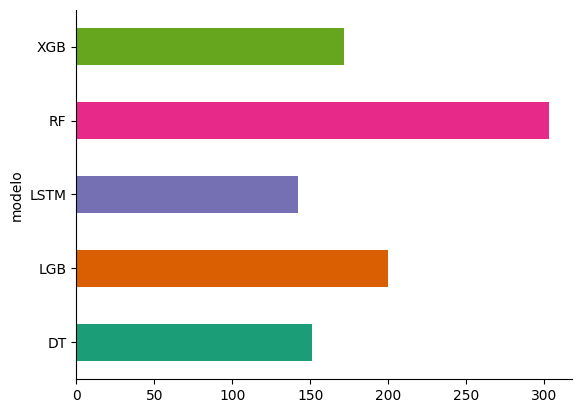

In [ ]:
best_rmse_by_ml.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Ahora guardaremos también la ejecución con Naive Bayes para la comparación de impacto.

In [ ]:
# Crear y entrenar el modelo Naive Bayes Gaussiano
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predicciones_nb = nb_model.predict(X_test)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predicciones_nb))
print("RMSE:", rmse)

# Calcular el Explained Variance Score (EVS)
evs = explained_variance_score(y_test, predicciones_nb)
print("EVS:", evs)



RMSE: 8.798159111989081
EVS: -1.0064236005974823


In [ ]:
# Crear un DataFrame con los resultados
resultados_nb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_nb['udsVenta_predichas'] = predicciones_nb
rmse_por_producto_nb = resultados_nb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_nb.columns = ['producto', 'RMSE']

In [ ]:
rmse_por_producto_nb

,producto,RMSE
0,1,34.217790
1,2,28.819255
2,3,23.303068
3,4,14.388258
4,5,13.575592
...,...,...
963,996,4.260733
964,997,3.877237
965,998,4.160251
966,999,6.268708


In [ ]:
# Guardar el resultado en un archivo CSV
rmse_por_producto_nb.to_csv('/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/rmse_by_product_nb_final.csv', index=False)

# **Naive**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, explained_variance_score

# Supongamos que train, validation, y test ya están definidos como DataFrames

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Crear y entrenar el modelo Naive Forecast
class NaiveForecastModel:
    def fit(self, X, y):
        self.last_value_ = y.iloc[-1]  # Usar iloc para obtener el último valor

    def predict(self, X):
        return np.full(shape=len(X), fill_value=self.last_value_)

# Crear una instancia del modelo Naive Forecast
nf_model = NaiveForecastModel()
nf_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predicciones_nf = nf_model.predict(X_test)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predicciones_nf))
print("RMSE:", rmse)

# Calcular el Explained Variance Score (EVS)
evs = explained_variance_score(y_test, predicciones_nf)
print("EVS:", evs)


RMSE: 6.490562894250765
EVS: 0.0


In [ ]:
# Crear un DataFrame con los resultados
resultados_nf = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_nf['udsVenta_predichas'] = predicciones_nf
rmse_por_producto_nf = resultados_nf.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_nf.columns = ['producto', 'RMSE']

In [ ]:
rmse_por_producto_nf

,producto,RMSE
0,1,30.646155
1,2,24.299414
2,3,20.908224
3,4,20.679660
4,5,21.300828
...,...,...
963,996,3.503530
964,997,3.680958
965,998,4.688072
966,999,9.527865


In [ ]:
# Guardar el resultado en un archivo CSV
rmse_por_producto_nf.to_csv('/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/rmse_by_product_nf_final.csv', index=False)